In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.io import loadmat
from datetime import datetime, timedelta
sys.path.append('/home/manu/TFG_repo/scripts')

In [9]:
from analysis_routines import *
from config import data_dir, reports_dir
from plotting_routines_xr import *
from processing_routines import datenum_to_epoch
from wavelet_analysis import wavelet_power_spectrum
from harmonic_analysis import *
plt.style.use('/home/manu/TFG_repo/notebooks/report.mplstyle')

In [4]:
# load data and fit
fit_chain = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
chain = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')
station7 = load_time_series_xr('station7_complete.nc')

In [5]:
# global variables
figures_dir = reports_dir / 'figures'

# Capitulo 1: Conceptos básicos de onceanografía física

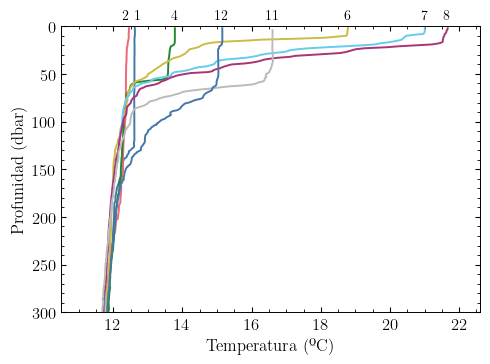

In [11]:
# profiles_2014
fig, ax = plt.subplots()
year = station7.temp.sel(date='2014')
months_int = [0, 1, 3, 5, 6, 7, 10, 11]
for i in months_int:
    #k = i*2 + 1
    ax.plot(year[i], station7.pres)
    if i==0:
        ax.text(year[i][np.isfinite(year[i])][3] +0.1, -8, i + 1, ha='center')
    elif i==1:
        ax.text(year[i][np.isfinite(year[i])][3] -0.1, -8, i + 1, ha='center')     
    else:
        ax.text(year[i][np.isfinite(year[i])][3], -8, i + 1, ha='center')
ax.set_ylim(300, 0)
ax.set_xlim(10.5, None)
ax.set_xlabel('Temperatura (ºC)')
ax.set_ylabel('Profunidad (dbar)')
fig.tight_layout()
fig.savefig(reports_dir / 'figures/profiles_2014.pdf', dpi=300)
plt.show()

# Capitulo 5: Ondas internas

In [13]:
chain.depth

<xarray.DataArray 'depth' (depth: 16)>
array([  1,   8,  23,  28,  33,  43,  48,  53,  63,  78,  96, 108, 126, 151,
       176, 201], dtype=int32)
Coordinates:
  * depth    (depth) int32 1 8 23 28 33 43 48 53 63 78 96 108 126 151 176 201

In [61]:
# espectros termistores welch

temp_28 = chain.temp.loc[:, 28].data
freqs_28, psd_28, dof_28 = windowed_spectrum(temp_28, 5/60/60/24, 28, 3) #window 42.67

temp_53 = chain.temp.loc[:, 53].data
freqs_53, psd_53, dof_53 = windowed_spectrum(temp_53, 5/60/60/24, 28, 3) #window 42.67

temp_63 = chain.temp.loc[:, 63].data
freqs_63, psd_63, dof_63 = windowed_spectrum(temp_63, 5/60/60/24, 28, 3) #window 42.673

temp_96 = chain.temp.loc[:, 96].data
freqs_96, psd_96, dof_96 = windowed_spectrum(temp_96, 5/60/60/24, 28, 3) #window 42.67

temp_176 = chain.temp.loc[:, 176].data
freqs_176, psd_176, dof_176 = windowed_spectrum(temp_176, 5/60/60/24, 28, 3) #window 42.67

#temp_4 = data.temp[:, 4].data
#freqs_temp_4, psd_temp_4, dof_temp_4 = windowed_spectrum(temp_4, 5/60/60/24, 28, 3) #window 42.67

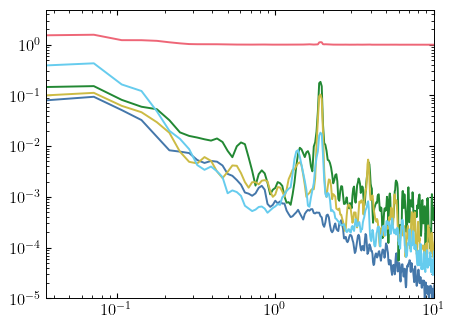

In [63]:
fig, ax = plt.subplots()
psd_53_of = 10**(np.log(psd_53 + 1))
ax.loglog(freqs_28, psd_28)
ax.loglog(freqs_53, psd_53_of)
ax.loglog(freqs_63, psd_63)
ax.loglog(freqs_96, psd_96)
ax.loglog(freqs_176, psd_176)
ax.set_xlim(min(freqs_28), 10**1)
ax.set_ylim(10**-5, None)
plt.show()

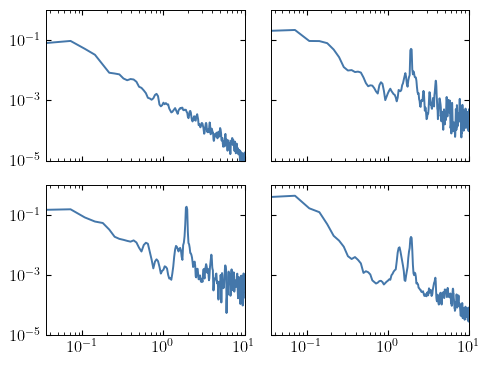

In [42]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

#limits
axs[0,0].set_xlim(min(freqs_28), 10**1)
axs[0,0].set_ylim(10**-5, None)


axs[0,0].loglog(freqs_28, psd_28)
axs[0,1].loglog(freqs_53, psd_53)
axs[1,0].loglog(freqs_63, psd_63)
axs[1,1].loglog(freqs_176, psd_176)


fig.tight_layout()
plt.show()
